In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=111eee6be6bbc28d3aed46fed53282f3b9a08edb873d41e0f1b9d8565614ccdf
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [101]:
import pandas as pd
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql import SparkSession
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [11]:
spark = SparkSession.builder.appName("PCA_KMeansExample").getOrCreate()

In [13]:
train = spark.read.csv('/content/drive/MyDrive/Final Project/pre_processed_train.csv', header=True, inferSchema=True)

In [14]:
train.columns

['_c0',
 'Id',
 'Day',
 'Month',
 'Year',
 'Sequence',
 'meal_time',
 'is_snack',
 'is_drinks',
 'is_supplement',
 'is_workout',
 'Calories_value',
 'Carbs_value',
 'Fat_value',
 'Protein_value',
 'Sodium_value',
 'Sugar_value',
 'Calories_total',
 'Carbs_total',
 'Fat_total',
 'Fiber_total',
 'Protein_total',
 'Sodium_total',
 'Sugar_total',
 'Calories_goal',
 'Carbs_goal',
 'Fat_goal',
 'Fiber_goal',
 'Protein_goal',
 'Sodium_goal',
 'Sugar_goal',
 'DishName',
 'success_index',
 'Feature_Vector']

In [17]:
features = [
    'Day',
    'Month',
    'Year',
    'Sequence',
    'meal_time',
    'is_snack',
    'is_drinks',
    'is_supplement',
    'is_workout',
    'Calories_goal',
    'Carbs_goal',
    'Fat_goal',
    'Fiber_goal',
    'Protein_goal',
    'Sodium_goal',
    'Sugar_goal']

In [18]:
assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)
assembled_df = assembler.transform(train)

# **For visualization use pca to see how many clastering do i have**

In [19]:
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(assembled_df)
pca_result = pca_model.transform(assembled_df)

In [20]:
pca_result.select("id", "pca_features").show(truncate=False)

+---+---------------------------------------------+
|id |pca_features                                 |
+---+---------------------------------------------+
|1  |[-0.548863689338937,1.313654824559103E-4]    |
|1  |[0.7512820997246221,7.127906793301756E-4]    |
|1  |[0.7669124580641516,2.192595286805563E-4]    |
|1  |[-0.5987001570026577,-5.795069211903225E-5]  |
|1  |[-0.5961086214894699,-3.3067067484387347E-4] |
|1  |[-0.48469035271862887,-2.2057304047957494E-6]|
|1  |[0.7590971235810585,4.6584192847134407E-4]   |
|1  |[-0.653767862859754,-3.8103544137985226E-4]  |
|1  |[0.6949251680923568,6.188464046423551E-4]    |
|1  |[-0.6563670177773424,-2.1387452989129061E-4] |
|1  |[0.7525820723281645,6.318457175498526E-4]    |
|1  |[-0.482085264389615,-8.336941841592092E-5]   |
|1  |[-0.5423578060463916,-1.701330233617874E-4]  |
|1  |[0.7382541303234178,0.0010832043668281995]   |
|1  |[-0.5449546740253961,2.905203421176833E-5]   |
|1  |[0.6818964632274104,9.789011062794313E-4]    |
|1  |[-0.584

In [21]:
pca_rdd = pca_result.select("id", "pca_features").rdd

In [22]:
pca_data = pca_rdd.map(lambda row: (row['id'], row['pca_features'][0], row['pca_features'][1])).collect()

ids, pc1, pc2 = zip(*pca_data)

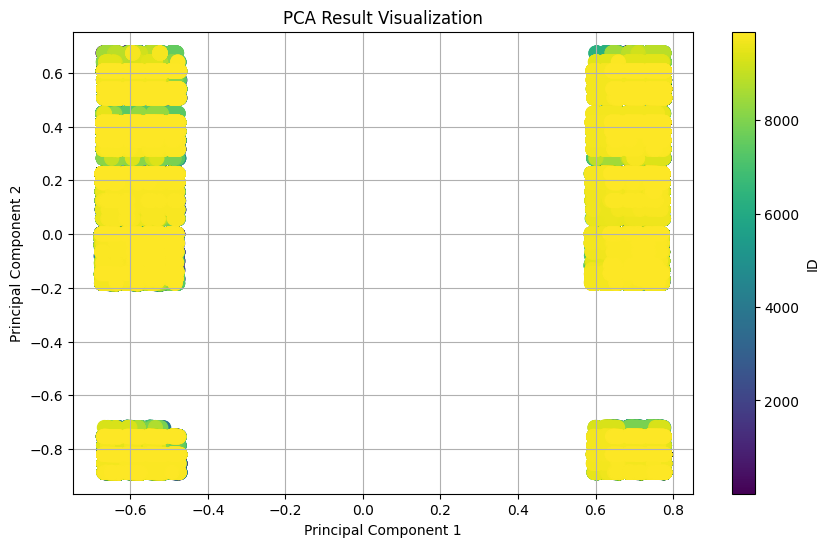

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(pc1, pc2, c=ids, cmap='viridis', s=100)

plt.colorbar(label='ID')

plt.title('PCA Result Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# **Experiment with K-Means algorithm**

In [25]:
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="cluster")

kmeans_model = kmeans.fit(assembled_df)

kmeans_result = kmeans_model.transform(assembled_df)

In [26]:
kmeans_result.show()

+---+---+------------------+------------------+----+--------+---------+--------+---------+-------------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+------------------+------------------+-----------------+------------------+------------------+------------------+----------+------------------+------------------+------------------+--------------------+------------------+--------------------+--------------------+-------+
|_c0| Id|               Day|             Month|Year|Sequence|meal_time|is_snack|is_drinks|is_supplement|is_workout|    Calories_value|       Carbs_value|         Fat_value|     Protein_value|      Sodium_value|       Sugar_value|    Calories_total|       Carbs_total|         Fat_total|Fiber_total|     Protein_total|      Sodium_total|      Sugar_total|     Calories_goal|        Carbs_goal|          Fat_goal|Fiber_goal|      Pr

In [27]:
cluster_counts = kmeans_result.groupBy("cluster").count()

In [28]:
cluster_counts.show()

+-------+-------+
|cluster|  count|
+-------+-------+
|      1|1149028|
|      3| 400314|
|      2|1080182|
|      0|2539686|
+-------+-------+



In [29]:
kmeans_result.write.mode("overwrite").parquet("/content/drive/MyDrive/Final Project/kmeans.parquet")
spark.stop()

In [30]:
spark = SparkSession.builder.appName("KNN").getOrCreate()

In [34]:
cluster_centers = kmeans_model.clusterCenters()

In [47]:
test = pd.read_csv('/content/drive/MyDrive/Final Project/pre_processed_test.csv')

In [78]:
user_1 = test.iloc[[322212],:]

In [79]:
def euclidean_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2) ** 2))

distances = [euclidean_distance(user_1[features].values, center) for center in cluster_centers]

closest_cluster_index = np.argmin(distances)
closest_cluster_distance = distances[closest_cluster_index]

print(f"Closest cluster index: {closest_cluster_index}")

Closest cluster index: 2


In [84]:
closest_center = cluster_centers[closest_cluster_index]

In [88]:
user_1.insert(0, 'cluster', closest_cluster_index)

In [89]:
user_1

,cluster,Index,Id,Day,Month,Year,Sequence,meal_time,is_snack,is_drinks,...,Sugar_total,Calories_goal,Carbs_goal,Fat_goal,Fiber_goal,Protein_goal,Sodium_goal,Sugar_goal,DishName,success_index
322212,2,322212,2530,0.56667,0.72727,0.0,0.2,0.666667,0.0,0.0,...,0.00005,0.08251,0.00104,0.00293,0.209675,0.002365,0.0,0.00077,"D'Angelo's - Med Turkey Pokket w amer cheese,l...",0.18857


In [92]:
spark = SparkSession.builder.appName('Read_Train').getOrCreate()
train = spark.read.parquet('/content/drive/MyDrive/Final Project/kmeans.parquet')

In [94]:
cluster_2_data = train.filter(train["cluster"] == 2)

In [97]:
selected_columns = cluster_2_data.select(features)

selected_columns.show()

+------------------+------------------+----+--------+------------------+--------+---------+-------------+----------+------------------+------------------+------------------+----------+------------------+------------------+------------------+
|               Day|             Month|Year|Sequence|         meal_time|is_snack|is_drinks|is_supplement|is_workout|     Calories_goal|        Carbs_goal|          Fat_goal|Fiber_goal|      Protein_goal|       Sodium_goal|        Sugar_goal|
+------------------+------------------+----+--------+------------------+--------+---------+-------------+----------+------------------+------------------+------------------+----------+------------------+------------------+------------------+
|0.4666666666666667|0.9090909090909092| 0.0|     0.4|               1.0|     0.0|      0.0|          0.0|       0.0|0.0645235537824152|0.0013599538910871|0.0014687368862778|       0.0| 8.159696925542E-4|0.0999608848711373|0.0017971758664955|
|0.5333333333333333|            

In [103]:
selected_columns_pd = selected_columns.toPandas()

user_1_features_array = user_1[features].values

user_1_features_reshaped = user_1_features_array.reshape(1, -1)
features_array = selected_columns_pd[features].values

similarities = cosine_similarity(features_array, user_1_features_reshaped)

selected_columns_pd['cosine_similarity'] = similarities

selected_columns_with_similarity = spark.createDataFrame(selected_columns_pd)

selected_columns_with_similarity.show()

+------------------+------------------+----+--------+------------------+--------+---------+-------------+----------+------------------+------------------+------------------+----------+------------------+------------------+------------------+------------------+
|               Day|             Month|Year|Sequence|         meal_time|is_snack|is_drinks|is_supplement|is_workout|     Calories_goal|        Carbs_goal|          Fat_goal|Fiber_goal|      Protein_goal|       Sodium_goal|        Sugar_goal| cosine_similarity|
+------------------+------------------+----+--------+------------------+--------+---------+-------------+----------+------------------+------------------+------------------+----------+------------------+------------------+------------------+------------------+
|0.4666666666666667|0.9090909090909092| 0.0|     0.4|               1.0|     0.0|      0.0|          0.0|       0.0|0.0645235537824152|0.0013599538910871|0.0014687368862778|       0.0| 8.159696925542E-4|0.099960884871